In [1]:
%load_ext autoreload
%autoreload 2
import os;
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.vaep.formula as vaepformula

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [5]:
## Configure file and folder names
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"predictions.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
print("nb of games:", len(games))

nb of games: 64


In [11]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(bodyparts,how="left")
        .merge(players,how="left")
        .merge(teams,how="left")
        .merge(results,how="left")
        .sort_values(["game_id","period_id","action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5,f"game_{game.game_id}")
    values = vaepformula.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)
A.columns

100%|██████████| 64/64 [00:04<00:00, 13.97it/s]


Index(['game_id', 'period_id', 'time_seconds', 'timestamp', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'bodypart_name',
       'player_name', 'player_nickname', 'jersey_number', 'country_id',
       'country_name', 'extra', 'team_name', 'result_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

### Most valuable players

In [12]:
A["count"] = 1

# These are useless events that don't measure player skill
       
playersR = (
    A[["player_id","vaep_value","offensive_value","defensive_value","count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
playersR = playersR.merge(players[["player_id","player_nickname","player_name"]],how="left")
playersR["player"] = playersR[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
playersR = playersR[["player_id","player","vaep_value","offensive_value","defensive_value","count"]]
playersR.sort_values("vaep_value",ascending=False)[:10]

,player_id,player,vaep_value,offensive_value,defensive_value,count
50,3308,Kieran Trippier,4.042022,4.516035,-0.474013,690
6,3009,Kylian Mbappé,3.661444,3.752109,-0.090665,495
599,20004,Paul Pogba,3.202148,2.904638,0.297510,676
17,3089,Kevin De Bruyne,3.080220,3.369482,-0.289262,716
36,3244,John Stones,3.045581,2.488402,0.557179,937
92,3621,Eden Hazard,3.017998,3.208908,-0.190909,691
122,4320,Neymar,2.946713,3.307150,-0.360437,749
152,5186,Denis Cheryshev,2.931364,3.768804,-0.837440,214
352,5574,Toni Kroos,2.766133,2.958893,-0.192760,647
71,3501,Philippe Coutinho,2.760350,2.671702,0.088648,703


In [13]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5,"player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id","minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
#stats[stats.offensive_rating > 0.1]
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating
352,5574,Toni Kroos,2.766133,2.958893,-0.192760,647,289,0.861426,0.921455
152,5186,Denis Cheryshev,2.931364,3.768804,-0.837440,214,312,0.845586,1.087155
251,5473,Ahmed Musa,1.822921,1.867842,-0.044921,162,220,0.745740,0.764117
34,3237,Sergio Agüero,1.566557,1.549919,0.016637,137,193,0.730519,0.722760
121,4319,Edinson Cavani,2.734364,2.789009,-0.054646,226,355,0.693219,0.707073
451,5674,Moussa Wagué,1.597771,1.602511,-0.004739,168,208,0.691343,0.693394
525,6196,Yerry Mina,2.376827,2.274127,0.102701,325,315,0.679094,0.649750
50,3308,Kieran Trippier,4.042022,4.516035,-0.474013,690,602,0.604289,0.675155
6,3009,Kylian Mbappé,3.661444,3.752109,-0.090665,495,550,0.599145,0.613982
122,4320,Neymar,2.946713,3.307150,-0.360437,749,478,0.554820,0.622685


### (optional) inspect Belgium's top 10 most valuable non-shot actions

2018-06-28 England 0-1 Belgium 9' dribble Michy Batshuayi Tunga


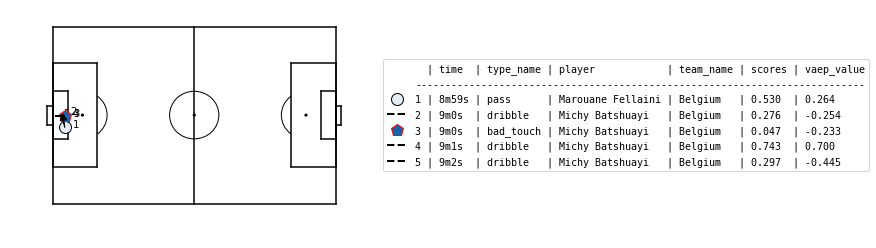

2018-06-23 Belgium 5-2 Tunisia 80' cross Kevin De Bruyne


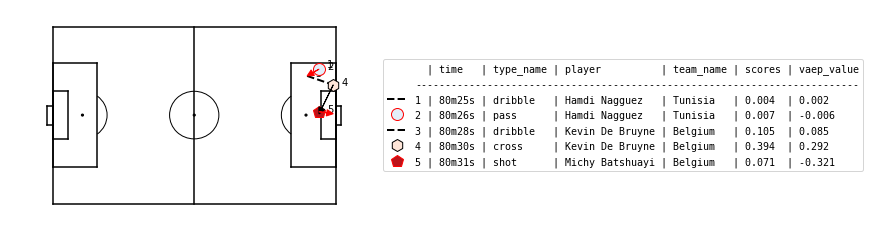

2018-07-02 Belgium 3-2 Japan 24' cross Dries Mertens


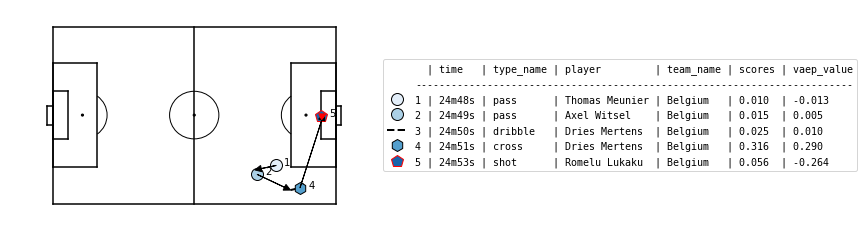

2018-06-28 England 0-1 Belgium 8' pass Marouane Fellaini-Bakkioui


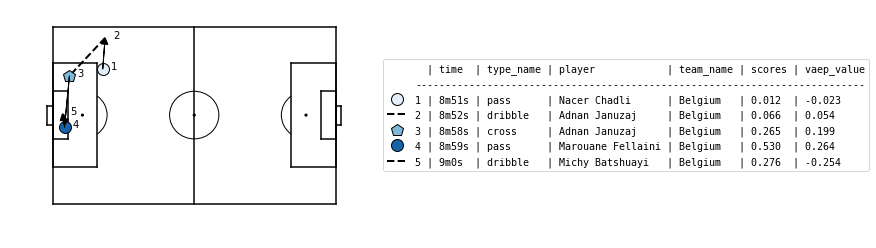

2018-07-02 Belgium 3-2 Japan 77' cross Nacer Chadli


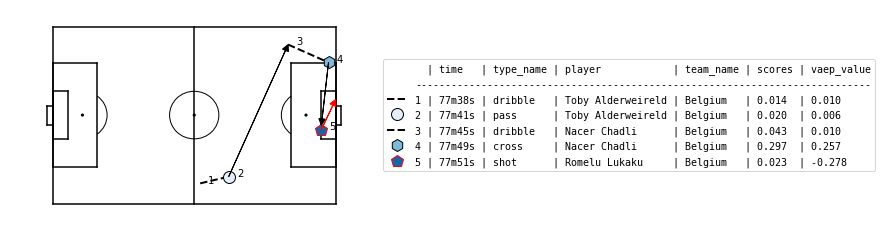

2018-06-23 Belgium 5-2 Tunisia 47' pass Thomas Meunier


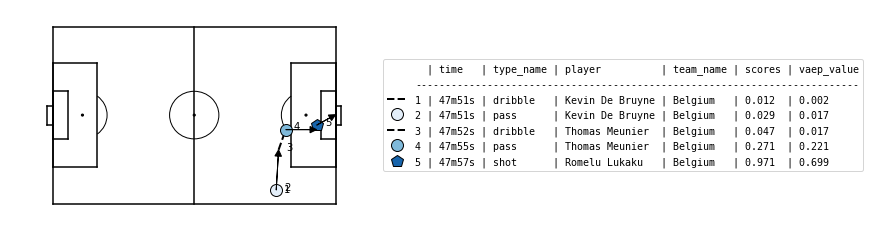

2018-06-23 Belgium 5-2 Tunisia 89' cross Youri Tielemans


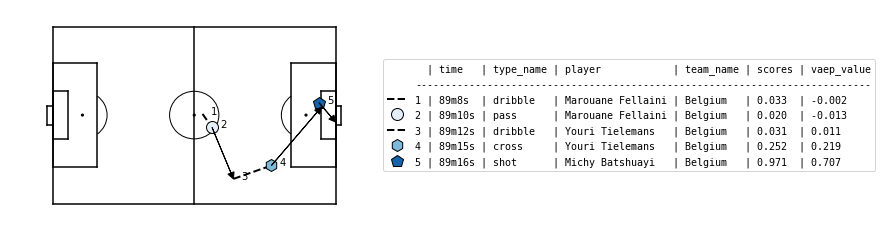

2018-07-02 Belgium 3-2 Japan 48' dribble Eden Hazard


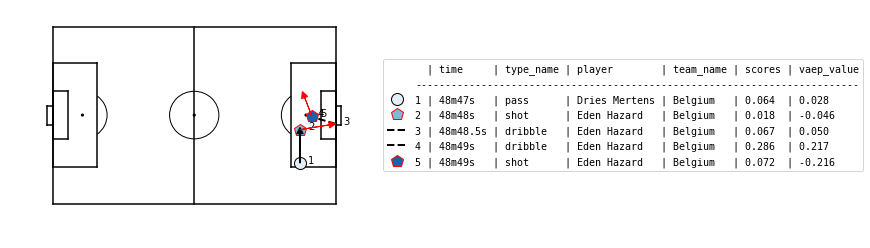

2018-07-10 France 1-0 Belgium 46' pass Axel Witsel


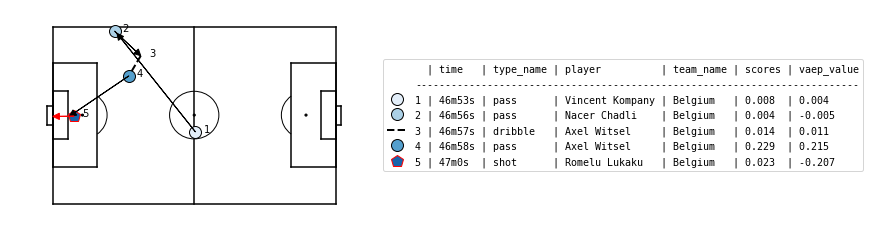

2018-07-10 France 1-0 Belgium 21' corner_crossed Nacer Chadli


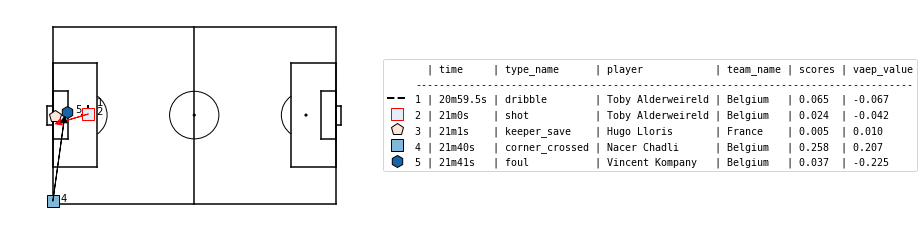

2018-07-02 Belgium 3-2 Japan 73' cross Eden Hazard


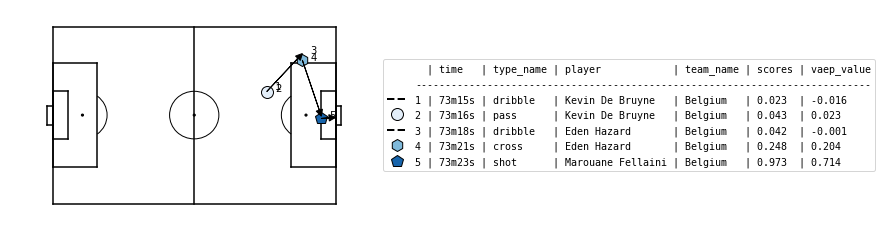

2018-07-02 Belgium 3-2 Japan 93' pass Thomas Meunier


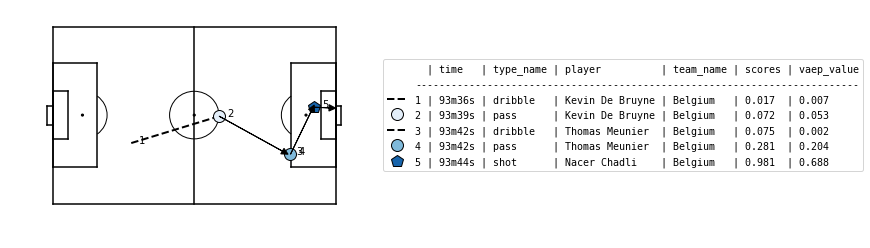

2018-06-28 England 0-1 Belgium 8' cross Adnan Januzaj


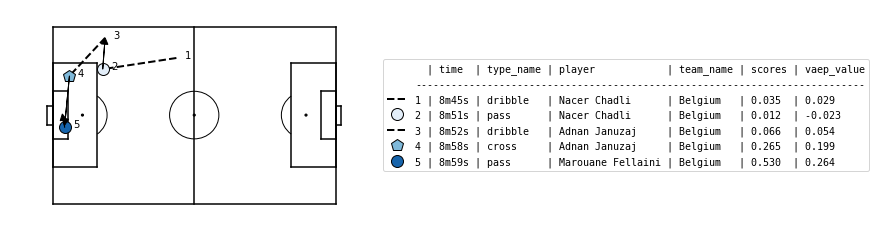

2018-06-18 Belgium 3-0 Panama 68' pass Kevin De Bruyne


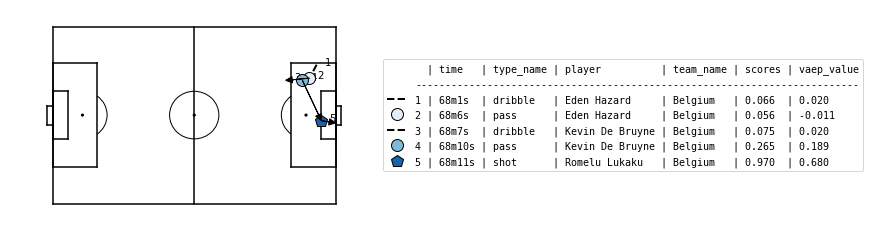

2018-07-14 Belgium 2-0 England 3' cross Nacer Chadli


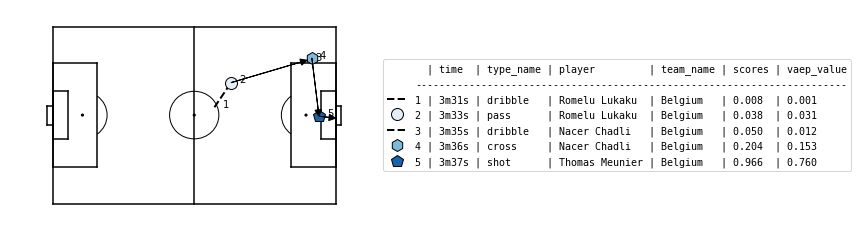

2018-07-06 Brazil 1-2 Belgium 14' pass Nacer Chadli


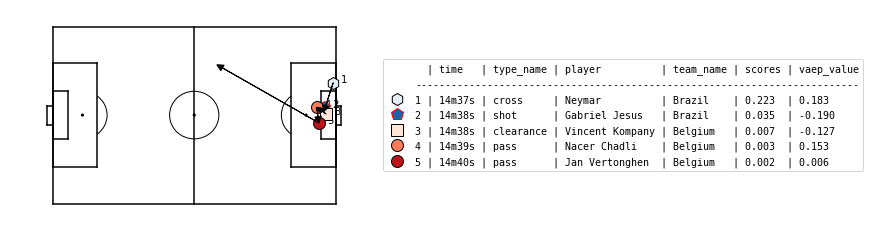

2018-07-14 Belgium 2-0 England 81' dribble Eden Hazard


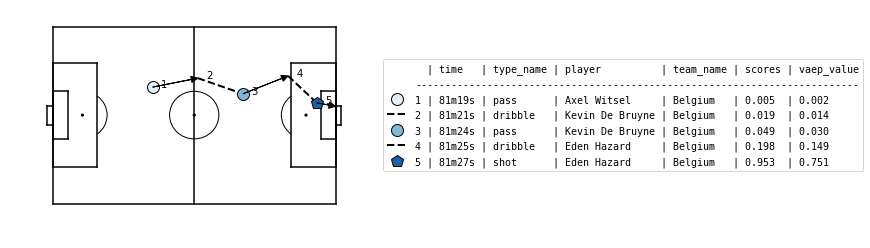

2018-07-02 Belgium 3-2 Japan 27' cross Kevin De Bruyne


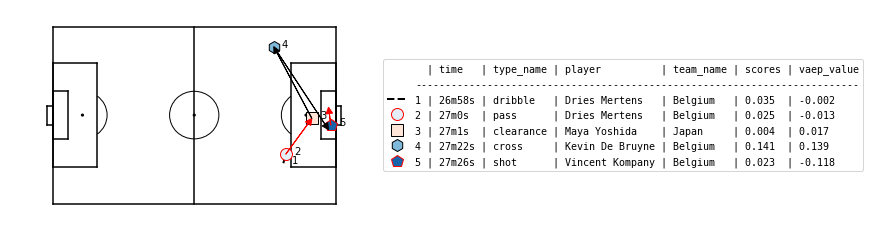

2018-07-02 Belgium 3-2 Japan 85' cross Thomas Meunier


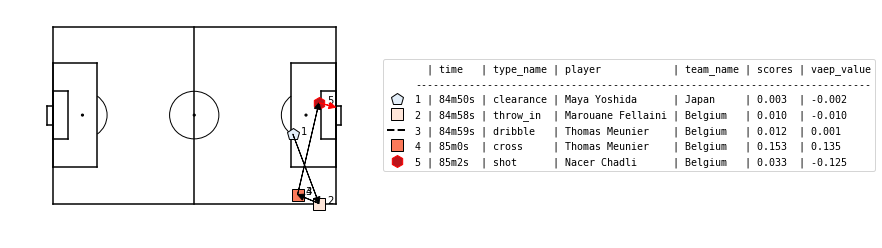

2018-07-10 France 1-0 Belgium 60' dribble Kevin De Bruyne


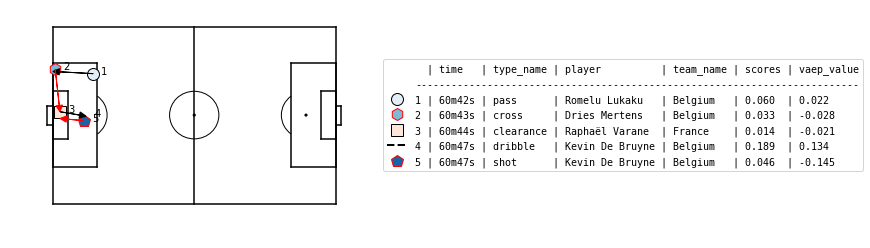

2018-07-02 Belgium 3-2 Japan 79' dribble Vincent Kompany


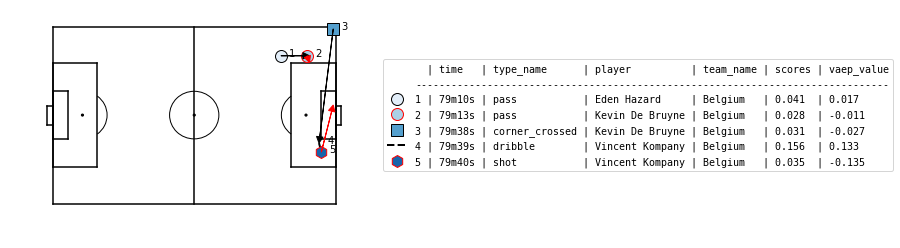

2018-06-23 Belgium 5-2 Tunisia 91' dribble Michy Batshuayi Tunga


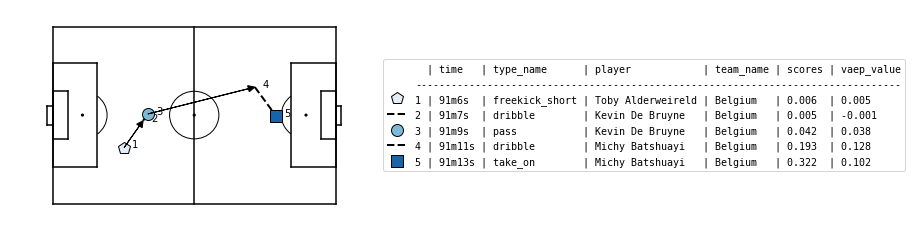

2018-06-23 Belgium 5-2 Tunisia 50' dribble Eden Hazard


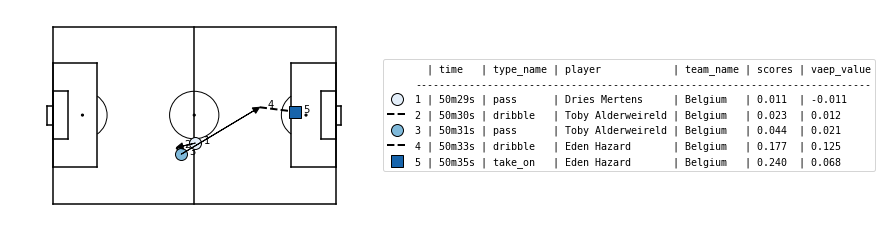

2018-06-18 Belgium 3-0 Panama 0' cross Yannick Ferreira Carrasco


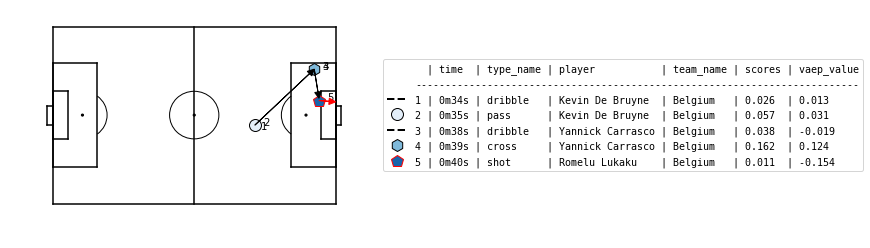

2018-06-23 Belgium 5-2 Tunisia 46' cross Kevin De Bruyne


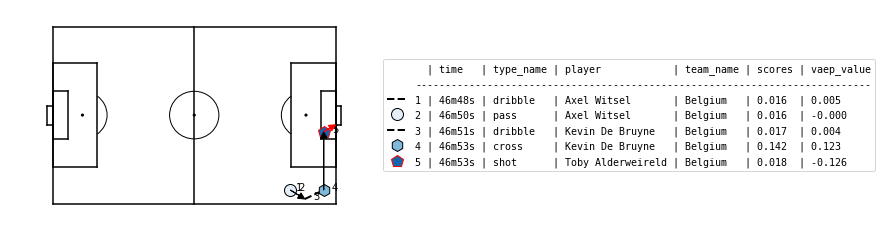

2018-07-02 Belgium 3-2 Japan 61' cross Thomas Meunier


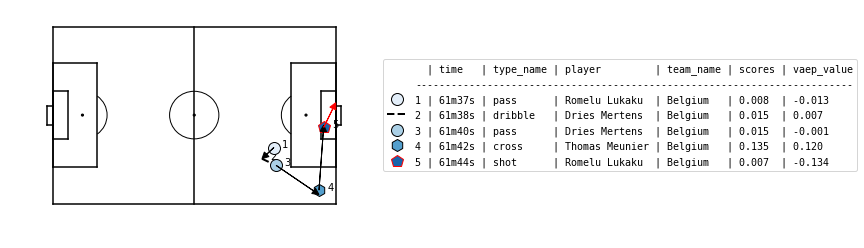

2018-07-02 Belgium 3-2 Japan 87' dribble Romelu Lukaku Menama


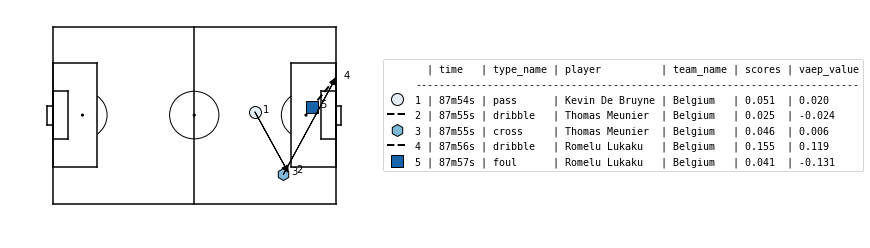

2018-07-14 Belgium 2-0 England 11' dribble Kevin De Bruyne


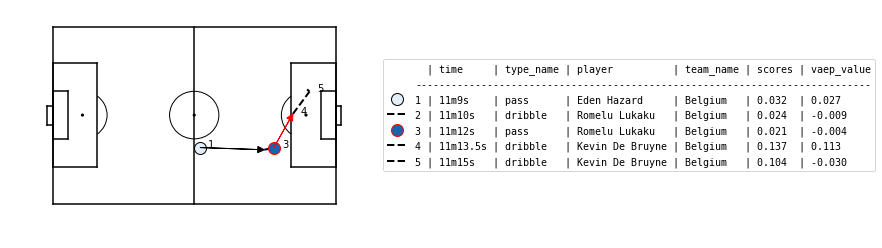

2018-06-23 Belgium 5-2 Tunisia 12' cross Romelu Lukaku Menama


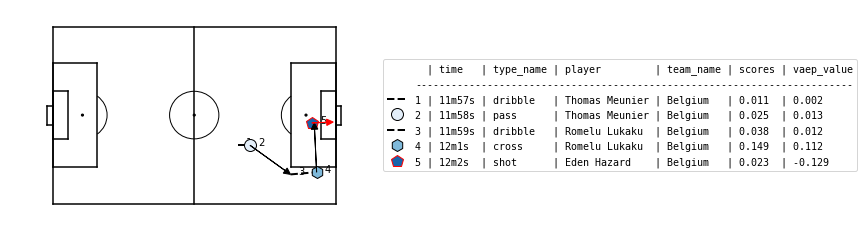

2018-07-06 Brazil 1-2 Belgium 61' dribble Vincent Kompany


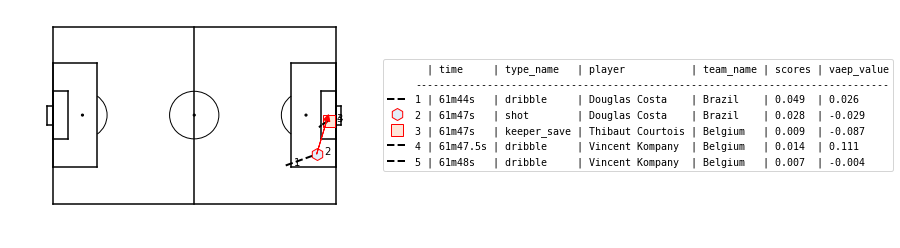

2018-07-02 Belgium 3-2 Japan 8' pass Dries Mertens


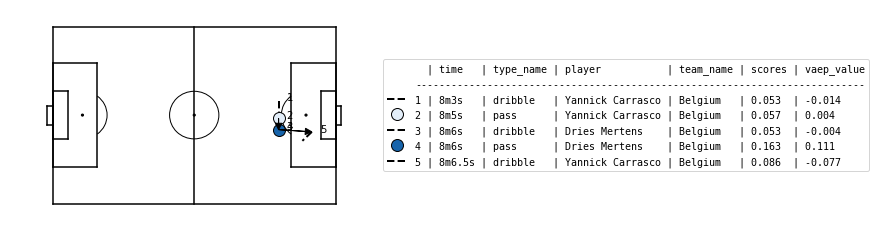

2018-06-23 Belgium 5-2 Tunisia 79' dribble Michy Batshuayi Tunga


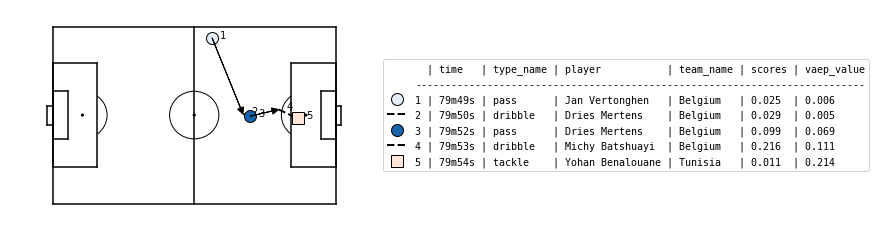

2018-06-23 Belgium 5-2 Tunisia 80' dribble Michy Batshuayi Tunga


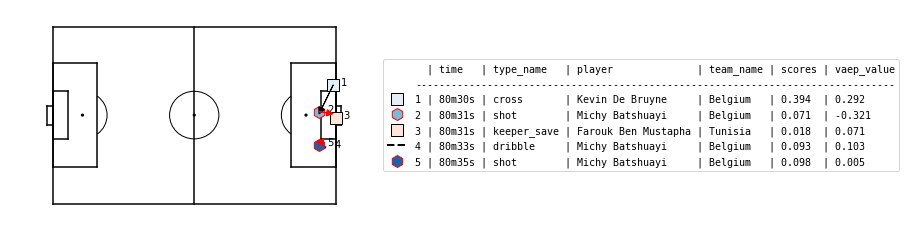

2018-06-23 Belgium 5-2 Tunisia 91' take_on Michy Batshuayi Tunga


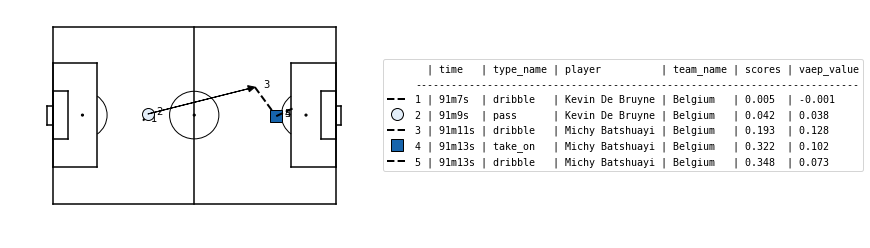

2018-06-23 Belgium 5-2 Tunisia 27' dribble Romelu Lukaku Menama


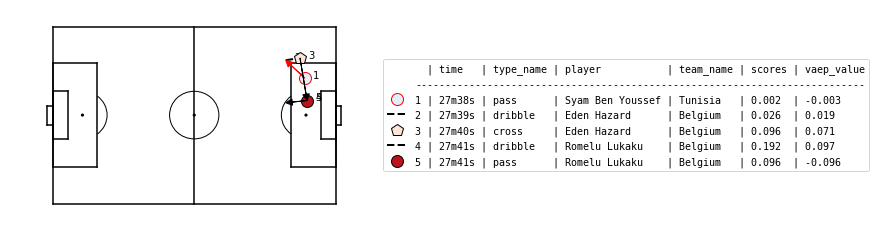

2018-06-18 Belgium 3-0 Panama 91' pass Moussa Sidi Yaya Dembélé


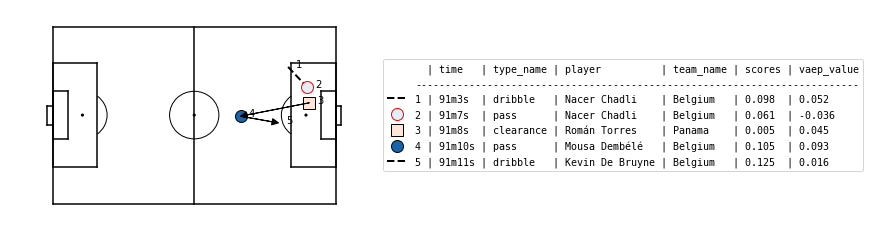

2018-06-23 Belgium 5-2 Tunisia 75' pass Dries Mertens


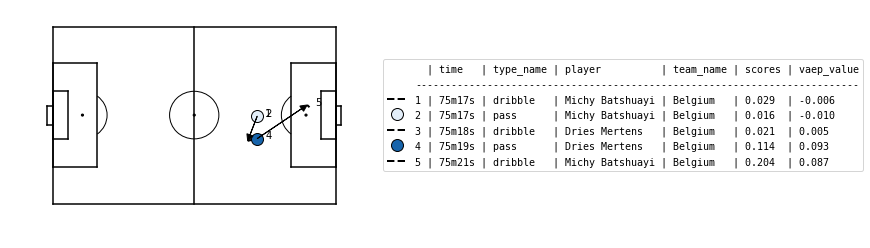

2018-06-28 England 0-1 Belgium 90' cross Michy Batshuayi Tunga


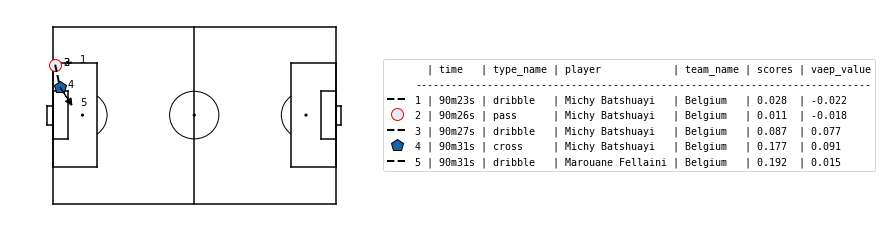

2018-06-28 England 0-1 Belgium 35' corner_crossed Thorgan Hazard


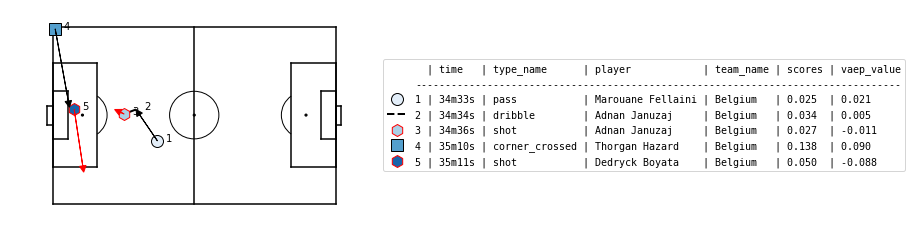

2018-06-18 Belgium 3-0 Panama 35' cross Thomas Meunier


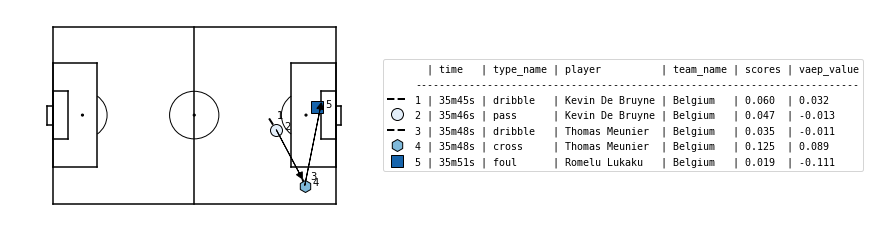

2018-07-02 Belgium 3-2 Japan 67' cross Thomas Meunier


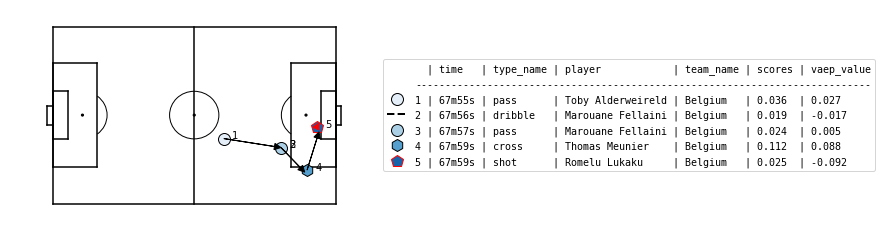

2018-07-02 Belgium 3-2 Japan 40' freekick_crossed Kevin De Bruyne


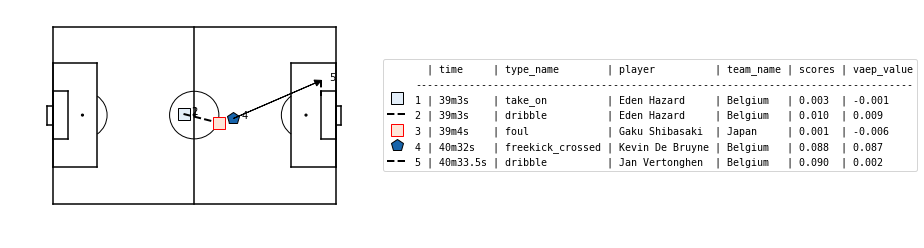

2018-06-23 Belgium 5-2 Tunisia 75' dribble Michy Batshuayi Tunga


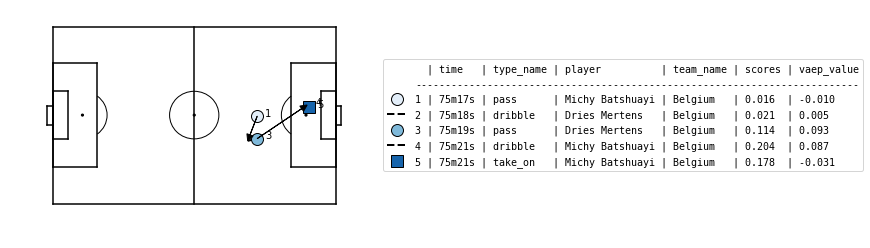

2018-06-28 England 0-1 Belgium 36' freekick_crossed Youri Tielemans


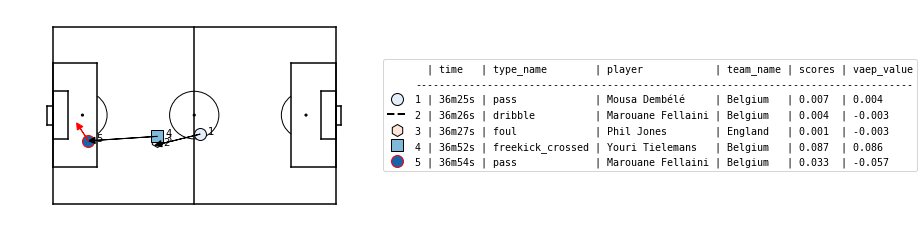

2018-06-23 Belgium 5-2 Tunisia 80' dribble Kevin De Bruyne


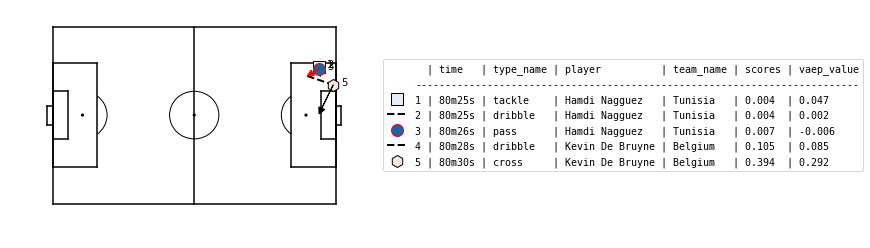

2018-07-10 France 1-0 Belgium 20' pass Marouane Fellaini-Bakkioui


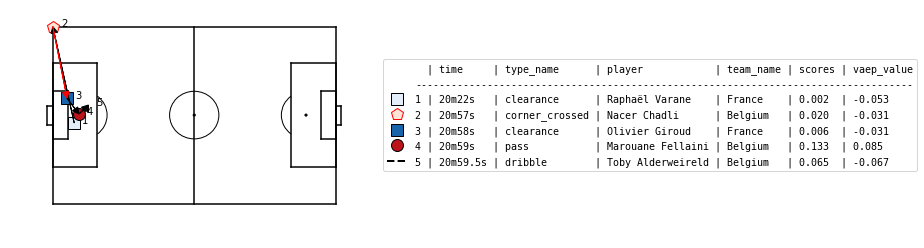

2018-07-02 Belgium 3-2 Japan 16' pass Thomas Meunier


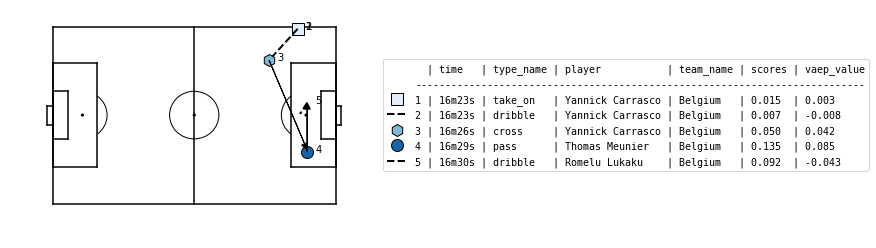

2018-07-14 Belgium 2-0 England 17' tackle Vincent Kompany


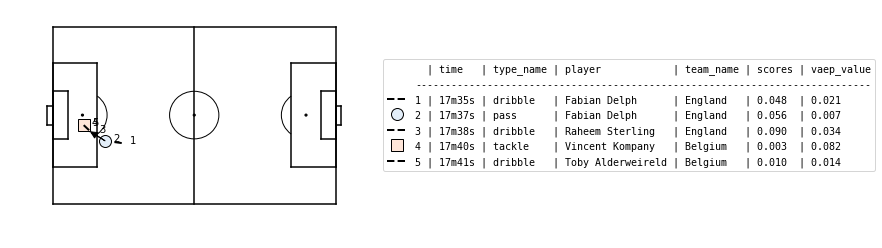

2018-06-23 Belgium 5-2 Tunisia 26' dribble Romelu Lukaku Menama


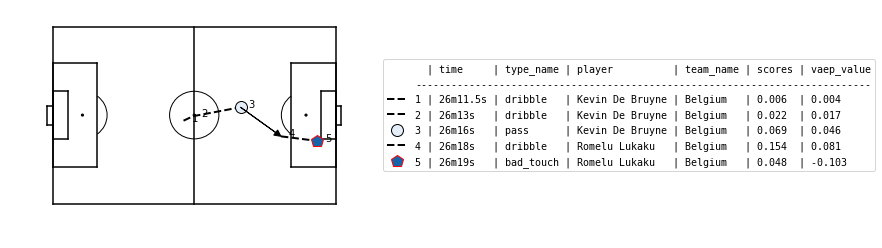

2018-07-14 Belgium 2-0 England 55' pass Kevin De Bruyne


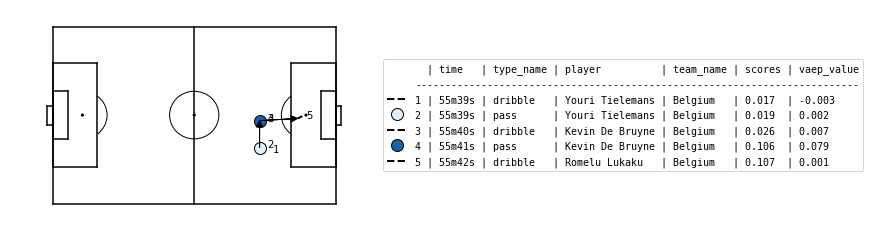

In [14]:
import matplotsoccer

sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0,50):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+2].copy()
    
    a["player"] = a[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time","type_name","player","team_name","scores","vaep_value"]
    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)